<a href="https://colab.research.google.com/github/alonacode/AI/blob/main/My_of_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D0%BA%D0%BB%D0%B0%D1%81%D0%B8%D1%84%D1%96%D0%BA%D1%96%D1%86%D1%96%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [11]:
import pandas as pd
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Дані про діабет

In [2]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/Healthcare-Diabetes.csv',
                 index_col='Id')

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Id,,,,,,,,,
1,0.352941,0.743719,0.590164,0.318182,0.000000,0.416873,0.234415,0.483333,1
2,0.058824,0.427136,0.540984,0.263636,0.000000,0.330025,0.116567,0.166667,0
3,0.470588,0.919598,0.524590,0.000000,0.000000,0.289082,0.253629,0.183333,1
4,0.058824,0.447236,0.540984,0.209091,0.111111,0.348635,0.038002,0.000000,0
5,0.000000,0.688442,0.327869,0.318182,0.198582,0.534739,0.943638,0.200000,1


Потрібно на основі інформації пацієнта виявити наявність діабету `Outcome`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [6]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values)
      self.y = torch.FloatTensor(y.values)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['Outcome'])
y = df['Outcome']

dataset = MyDataset(X, y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y)

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

# Завдання 2
Створіть DataLoader

In [13]:
from torch.utils.data import DataLoader

batch_size = 128
train_dl = DataLoader(dataset_train,  # датасет з даними
                      batch_size=batch_size,  # кількість даних в одному пакеті
                      shuffle=True,          # чи треба перемішувати дані
                      )  # підключення до процесора

test_dl = DataLoader(dataset_test,  # датасет з даними
                     batch_size=batch_size,  # кількість даних в одному пакеті
                     shuffle=True,        # чи треба перемішувати дані
                     )  # підключення до процесора

# Завдання 3
Створіть нейромережу

In [17]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim//3)
        self.linear3 = nn.Linear(hidden_dim//3, hidden_dim//3)
        self.linear4 = nn.Linear(hidden_dim//3, output_dim)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)

        out = self.linear2(out)
        out = F.relu(out)

        out = self.linear3(out)
        out = F.relu(out)

        out = self.linear4(out)
        out = F.sigmoid(out)
        return out

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.cpu().numpy()


model = BinaryClassifier(8, 100, 1).to(device)
model

BinaryClassifier(
  (linear1): Linear(in_features=8, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=33, bias=True)
  (linear3): Linear(in_features=33, out_features=1, bias=True)
)

# Завдання 4
Визначте функцію втрат та оптимізатор

In [18]:
from torchsummary import summary

summary(model, input_size=(8,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             900
            Linear-2                   [-1, 33]           3,333
            Linear-3                    [-1, 1]              34
Total params: 4,267
Trainable params: 4,267
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [19]:
# Функція втрат середньоквадратичної помилки (MSE) для регресії
loss_fn = nn.BCELoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# Завдання 5
Натренуйте нейромережу. Візміть невелику кількість епох

In [20]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [21]:
from sklearn.metrics import accuracy_score, recall_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=20,
                metrics=[accuracy_score, recall_score],
                device=device,
                task='binary')

train() called: model=BinaryClassifier, opt=SGD(lr=0.010000), epochs=20, device=cpu

Epoch    1    0sec	loss:       0.69	val_loss:      0.686	accuracy_score:      0.657	val_accuracy_score:      0.653	recall_score:     0.0992	val_recall_score:          0	
Epoch    2    0sec	loss:      0.683	val_loss:      0.681	accuracy_score:      0.656	val_accuracy_score:      0.655	recall_score:          0	val_recall_score:          0	
Epoch    3    0sec	loss:      0.678	val_loss:      0.676	accuracy_score:      0.656	val_accuracy_score:      0.655	recall_score:          0	val_recall_score:          0	
Epoch    4    0sec	loss:      0.674	val_loss:      0.672	accuracy_score:      0.656	val_accuracy_score:      0.655	recall_score:          0	val_recall_score:          0	
Epoch    5    0sec	loss:       0.67	val_loss:      0.668	accuracy_score:      0.656	val_accuracy_score:      0.655	recall_score:          0	val_recall_score:          0	
Epoch    6    0sec	loss:      0.666	val_loss:      0.665	accuracy

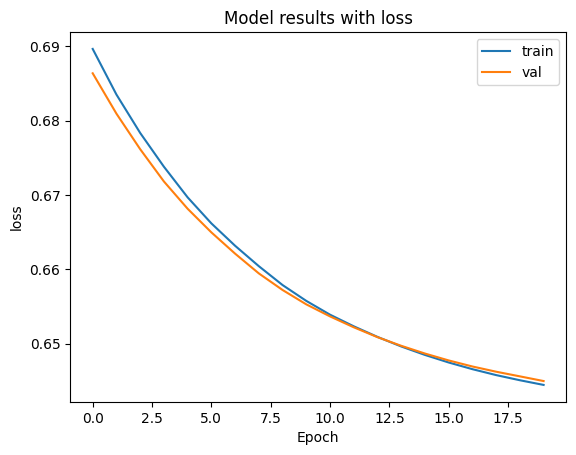

In [22]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()


plot_metric(history, 'loss')

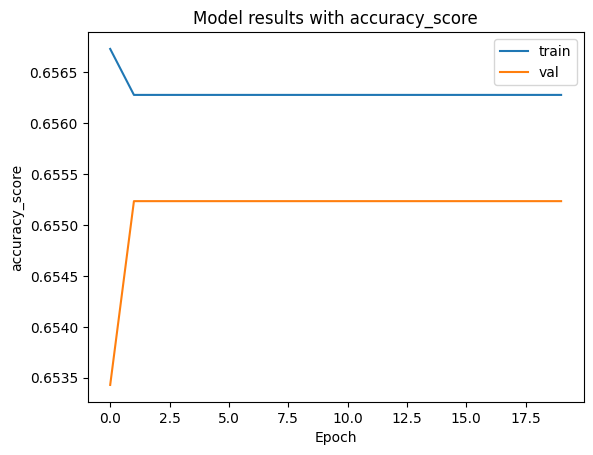

In [23]:
plot_metric(history, 'accuracy_score')

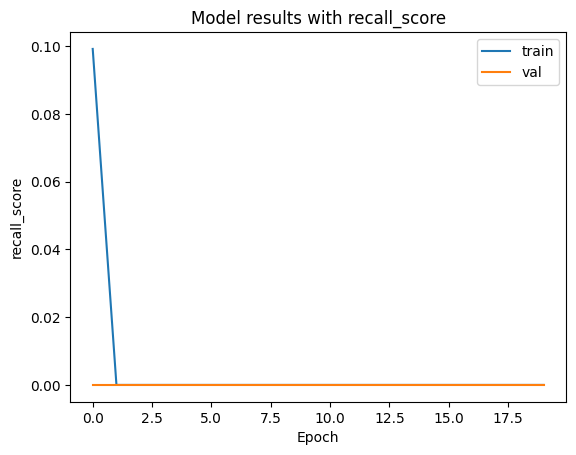

In [24]:
plot_metric(history, 'recall_score')

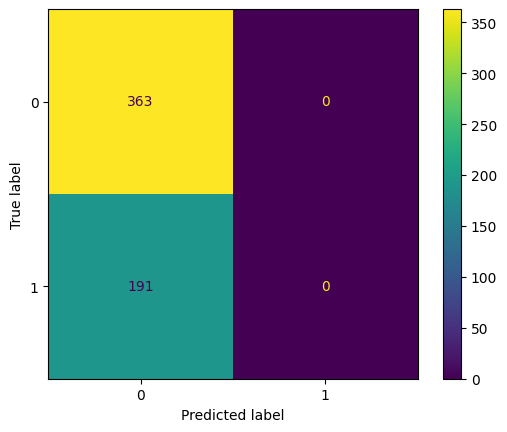

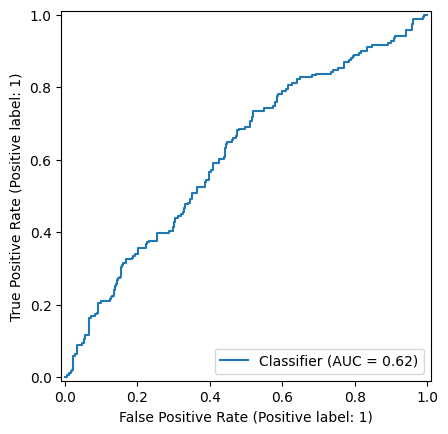

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to('cpu')  # відключаємо від gpu
y_pred = model.predict(X_test, device)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)

In [26]:
from sklearn.metrics import classification_report

report = classification_report(y_true=y_test, y_pred=y_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.66      1.00      0.79       363
           1       0.00      0.00      0.00       191

    accuracy                           0.66       554
   macro avg       0.33      0.50      0.40       554
weighted avg       0.43      0.66      0.52       554



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [27]:
torch.save(model, 'model.pt')

In [28]:
load_model = torch.load('model.pt')

<ipython-input-28-2cff9b381423>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model = torch.load('model.pt')


In [29]:
load_model

BinaryClassifier(
  (linear1): Linear(in_features=8, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=33, bias=True)
  (linear3): Linear(in_features=33, out_features=1, bias=True)
)

In [30]:
X.iloc[:1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Id,,,,,,,,
1,0.352941,0.743719,0.590164,0.318182,0.0,0.416873,0.234415,0.483333


In [31]:
with torch.no_grad():
    for batch in test_dl:
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)

        # Робимо прогноз
        predictions = model(X_batch)


        print(predictions)

tensor([[0.3827],
        [0.3788],
        [0.3883],
        [0.3920],
        [0.3785],
        [0.3739],
        [0.3762],
        [0.3759],
        [0.3866],
        [0.3761],
        [0.3821],
        [0.3790],
        [0.3827],
        [0.3876],
        [0.3758],
        [0.3834],
        [0.3803],
        [0.3895],
        [0.3834],
        [0.3755],
        [0.3821],
        [0.3888],
        [0.3766],
        [0.3731],
        [0.3798],
        [0.3828],
        [0.3746],
        [0.3822],
        [0.3838],
        [0.3744],
        [0.3826],
        [0.3798],
        [0.3929],
        [0.3843],
        [0.3928],
        [0.3715],
        [0.3824],
        [0.3856],
        [0.3761],
        [0.3783],
        [0.3747],
        [0.3841],
        [0.3869],
        [0.3814],
        [0.3768],
        [0.3887],
        [0.3819],
        [0.3895],
        [0.3767],
        [0.3787],
        [0.3800],
        [0.3832],
        [0.3858],
        [0.3820],
        [0.3768],
        [0